# MNIST 분류기 실습
- 목표: Augmentation을 통해 정확도 99.5% 달성 (DeepLearning 미션 난이도(중)-3 문제)
- 모델은 아주 간단하게 구현
- CustomDataset구현
- Wandb를 사용하여 모델 학습 상황 확인

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc
from PIL import Image

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import wandb

## data load

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(len(train_images), len(train_labels))
print(len(test_images), len(test_labels))

60000 60000
10000 10000


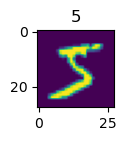

In [3]:
plt.figure(figsize=(1, 1))
plt.imshow(train_images[0])
plt.title(train_labels[0])
plt.show()

In [4]:
print(f'image shape: {train_images[0].shape}')

image shape: (28, 28)


## CustomDataset

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms):
        self.data = list((transforms(image), label) for image, label in zip(images, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][1]

        return self.data[idx]

In [6]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(degrees=15),      # 15도 범위 내에서 회전
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 10% 내에서 이동
    T.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # 크기 조정 및 자르기
    T.Normalize((0.1307,), (0.3081,))  # 정규화
])

transforms = T.Compose([
    T.ToTensor()
])

In [7]:
train_dataset1 = CustomDataset(train_images, train_labels, transforms) # 일반 데이터
train_dataset2 = CustomDataset(train_images, train_labels, aug_transforms) # 증강 데이터
test_dataset = CustomDataset(test_images, test_labels, transforms)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2]) # train dataset 2개를 합친다.

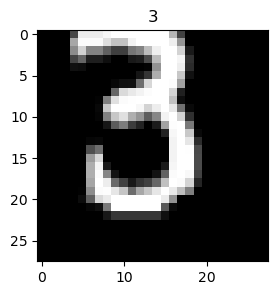

In [9]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[70052][0].squeeze().numpy(), cmap='gray')
plt.title(train_dataset[70052][1])
plt.show()

In [10]:
# train,valid split
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [11]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

96000
24000
10000


## Model

In [12]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.max_pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(128 * 3 * 3, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = torch.nn.functional.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = x.view(-1, 128 * 3 * 3)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        output = self.logsoftmax(x)
        
        return output

## DataLoader

In [13]:
batch_size = 6000

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Wandb 설정

In [16]:
# wandb login

wandb.login(key='')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/kimhongseok/.netrc


True

In [17]:
# 학습 로그를 저장할 레포 설정
run = wandb.init(project='DL_mission_middle_3', name='training')

## train, eval 함수

In [19]:
def training(model, train_dataloader, train_dataset, critreion, optimizer, epoch, num_epochs, device):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = critreion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (labels == predicted).sum().item()

        tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs, device):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def train_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs, device)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs, device)

        # monitoring_value = {'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy} # 로그에 저장할 데이터 설정
        # run.log(monitoring_value, step=epoch) # 로그 저장

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    return model

In [20]:
model = CNN()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('mps')

# wandb에 모델의 weight & bias, gradient를 시각화한다.
# run.watch(model, criterion, log='all', log_graph=True)

model = train_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 15, device)
# run.finish()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/15], Train Loss: 1.5910, Train Accuracy: 0.5274 Valid Loss: 0.8289, Valid Accuracy: 0.7958


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/15], Train Loss: 0.6312, Train Accuracy: 0.8379 Valid Loss: 0.3904, Valid Accuracy: 0.9027


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/15], Train Loss: 0.3421, Train Accuracy: 0.9102 Valid Loss: 0.2270, Valid Accuracy: 0.9390


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/15], Train Loss: 0.2186, Train Accuracy: 0.9385 Valid Loss: 0.1580, Valid Accuracy: 0.9527


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/15], Train Loss: 0.1662, Train Accuracy: 0.9506 Valid Loss: 0.1277, Valid Accuracy: 0.9625


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/15], Train Loss: 0.1367, Train Accuracy: 0.9593 Valid Loss: 0.1123, Valid Accuracy: 0.9654


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/15], Train Loss: 0.1170, Train Accuracy: 0.9648 Valid Loss: 0.0943, Valid Accuracy: 0.9715


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/15], Train Loss: 0.1025, Train Accuracy: 0.9693 Valid Loss: 0.0853, Valid Accuracy: 0.9744


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/15], Train Loss: 0.0924, Train Accuracy: 0.9716 Valid Loss: 0.0797, Valid Accuracy: 0.9765


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/15], Train Loss: 0.0843, Train Accuracy: 0.9744 Valid Loss: 0.0807, Valid Accuracy: 0.9747


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/15], Train Loss: 0.0791, Train Accuracy: 0.9755 Valid Loss: 0.0679, Valid Accuracy: 0.9801


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/15], Train Loss: 0.0695, Train Accuracy: 0.9785 Valid Loss: 0.0665, Valid Accuracy: 0.9802


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/15], Train Loss: 0.0667, Train Accuracy: 0.9796 Valid Loss: 0.0631, Valid Accuracy: 0.9808


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/15], Train Loss: 0.0614, Train Accuracy: 0.9810 Valid Loss: 0.0585, Valid Accuracy: 0.9830


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/15], Train Loss: 0.0540, Train Accuracy: 0.9832 Valid Loss: 0.0553, Valid Accuracy: 0.9835


In [20]:
#torch.save(model.state_dict(), './model.pt')

## test

In [21]:
#model = CNN()
#model.load_state_dict(torch.load('./model.pt'))

model.to(device)
model.eval()
total_labels = []
total_preds = []
with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        
        total_preds.extend(predicted.tolist())
        total_labels.extend(labels.tolist())

  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
accuracy_score(total_labels, total_preds)

0.9914